# Importing packages & modules

In [1]:
import sys
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Add parent directory to sys.path to import tsad modules
sys.path.insert(1, '../')

# Import custom modules
from tsad.base.pipeline import Pipeline

# Import tsad tasks for pipeline
from tsad.tasks.eda import HighLevelDatasetAnalysisTask, TimeDiscretizationTask
from tsad.tasks.eda import FindNaNTask, EquipmentDowntimeTask
from tsad.tasks.preprocess import ResampleProcessingTask
from tsad.tasks.preprocess import SplitByNaNTask, PrepareSeqSamplesTask
from tsad.tasks.deep_learning_forecasting import DeepLeaningTimeSeriesForecastingTask

# Creating tsad StandardScaler task (need for pipeline) by using tsad Sklearn Wrapper
from tsad.base.wrappers import SklearnWrapper
StandardScalerTask = SklearnWrapper(StandardScaler)

# Data loading

In [2]:
# # Import function for loading the dataset
from tsad.base.datasets import load_skab

# Load the skab dataset in memory
dataset = load_skab()

# Get the feature and target names from the dataset
columns = dataset.feature_names
targets = dataset.target_names

# Get the dataframe from the dataset
df = dataset.frame

In [3]:
# Get the 0 level of the index of the dataframe
df.index.levels[0]

Index(['air/0', 'air/1', 'fluid/0', 'fluid/1', 'fluid/2', 'fluid/3', 'fluid/4',
       'fluid/5', 'rotor/0', 'rotor/1', 'rotor/2', 'rotor/3', 'rotor/4',
       'temperature/0', 'valve1/0', 'valve1/1', 'valve1/10', 'valve1/11',
       'valve1/12', 'valve1/13', 'valve1/14', 'valve1/15', 'valve1/2',
       'valve1/3', 'valve1/4', 'valve1/5', 'valve1/6', 'valve1/7', 'valve1/8',
       'valve1/9', 'valve2/0', 'valve2/1', 'valve2/2', 'valve2/3'],
      dtype='object', name='experiment')

# Train Test Split

In [4]:
# Split the dataset into train and test sets (and we need 
# to remove the labeling of the dataset for anomaly detection)
test_datasets = ['valve1/0', 'valve2/0', 'fluid/0']
train_raw = df.drop(test_datasets,level=0).droplevel(level=0).drop(columns=targets)
test_raw = df.loc[test_datasets].droplevel(level=0).drop(columns=targets)

In [5]:
train_raw.head(3)

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS
datetime,,,,,,,,
2020-03-09 12:14:36,0.027429,0.040353,0.77031,0.382638,71.2129,25.0827,219.789,32.0000
2020-03-09 12:14:37,0.027269,0.040226,1.09696,0.710565,71.4284,25.0863,233.117,32.0104
2020-03-09 12:14:38,0.027040,0.039773,1.14015,0.054711,71.3468,25.0874,234.745,32.0000


# Making and fit pipeline

## Hello world case

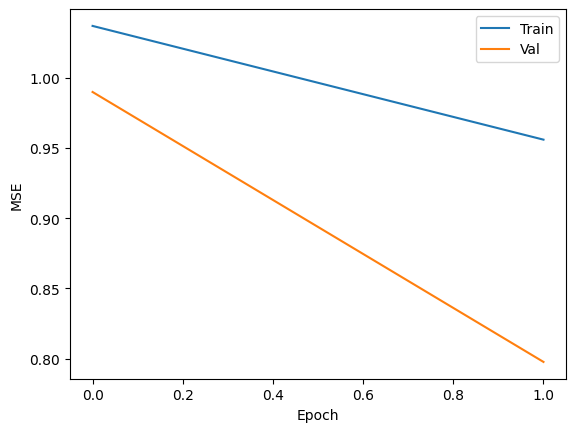

Epoch: 02 
	Train Loss: 0.956 
	 Val. Loss: 0.798 

Epoch: 01 
	Train Loss: 1.037 
	 Val. Loss: 0.990 


After choosing the best model:
Test Loss: 1.050


In [6]:
# Create a pipeline for multivariate time series deep learning forecasting with task set
from tsad.pipelines import multivatiateTimeSeriesDeepLearningForecastingTaskSet
simple_pipeline = Pipeline(multivatiateTimeSeriesDeepLearningForecastingTaskSet)

# Fit the pipeline on the train set
y_pred_train = simple_pipeline.fit(train_raw,n_epochs=2)

## Advanced Case

In [7]:
# Import tsad deep learning regressors
from tsad.utils.ml_models.deeplearning_regressors import MLP, SimpleLSTM, LSTM
# Get the number of features in the train set for neural network layers settings
k = train_raw.shape[1]

In [8]:
# For example we can create objects of deep learning regressors and
# can choose one from the following models:
classic_mlp = MLP([k,k,k,k])
autoencoder = MLP([k,int(k/2),int(k/2),k])
classic_lstm = SimpleLSTM(k,k)
bidirect_lstm = SimpleLSTM(k,k,bidirectional=True)
multilayerLSTM = LSTM(k,k)

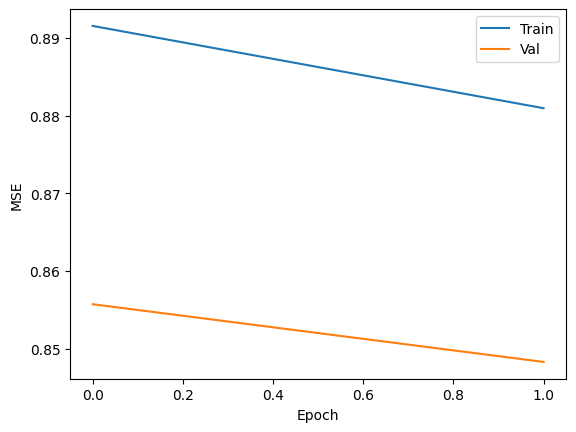

Epoch: 02 
	Train Loss: 0.881 
	 Val. Loss: 0.848 

Epoch: 01 
	Train Loss: 0.892 
	 Val. Loss: 0.856 


After choosing the best model:
Test Loss: 0.892
CPU times: total: 2.44 s
Wall time: 2.43 s


In [24]:
%%time 
#Measure the time taken to execute the pipeline

# We assemble a pipeline of imported tasks for multivariate time 
# series deep learning forecasting
pipeline = Pipeline([
    HighLevelDatasetAnalysisTask(),
    TimeDiscretizationTask(freq_tobe_approach='custom',freq_tobe='1s'),
    FindNaNTask(),
    EquipmentDowntimeTask(),
    ResampleProcessingTask(),
    StandardScalerTask(),
    SplitByNaNTask(),
    PrepareSeqSamplesTask(len_seq=10,gap=10),
    DeepLeaningTimeSeriesForecastingTask(),
], show=False)
# Fit the pipeline on the train set
y_pred_train = pipeline.fit(train_raw,n_epochs=2,model=classic_lstm)

# Inference of pipeline

In [26]:
y_pred = pipeline.predict(test_raw)

Skipped 125 datasets because the number of samples is too small in the dataset. (len_seq + points_ahead + gap -1 <= len(df))
124


# Getting y_true

In [28]:
raw_pipeline = Pipeline([
    HighLevelDatasetAnalysisTask(),
    TimeDiscretizationTask(freq_tobe_approach='custom',freq_tobe='1s'),
    FindNaNTask(),
    EquipmentDowntimeTask(),
    ResampleProcessingTask(),
    StandardScalerTask(),
    SplitByNaNTask(),
    PrepareSeqSamplesTask(len_seq=10,gap=10, test_size=0,what_to_shuffle='nothing')])
_, _, y_true, _ = raw_pipeline.fit(test_raw)

Skipped 125 datasets because the number of samples is too small in the dataset. (len_seq + points_ahead + gap -1 <= len(df))


# Comparing results

In [29]:
from sklearn.metrics import mean_squared_error as rmse

In [30]:
print(rmse(y_true=np.array(y_true).ravel(), y_pred=np.array(y_pred).ravel()))

0.9351780889905495
